# Deep Neural Network from Scratch

This notebook implements a 4-layer deep neural network using only NumPy for binary image classification (cat vs non-cat).

## Architecture

```
Input (12288) → Dense (20, ReLU) → Dense (7, ReLU) → Dense (5, ReLU) → Output (1, Sigmoid)
```

## Key Components

- **Forward propagation**: Vectorized computation through all layers
- **Backward propagation**: Gradient computation using chain rule
- **Optimization**: Gradient descent with configurable learning rate
- **Activation functions**: ReLU (hidden layers), Sigmoid (output layer)

## 1. Setup and Imports

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from PIL import Image
from utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Load and Explore Dataset

The dataset consists of 64×64 RGB images labeled as cat (1) or non-cat (0).

In [15]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

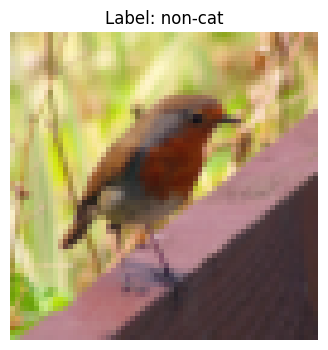

In [16]:
# Visualize a sample image
index = 10
plt.imshow(train_x_orig[index])
label = classes[np.squeeze(train_y[:, index])].decode("utf-8")
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [17]:
# Dataset dimensions
m_train = train_x_orig.shape[0]
m_test = test_x_orig.shape[0]
num_px = train_x_orig.shape[1]

print(f"Training examples: {m_train}")
print(f"Test examples: {m_test}")
print(f"Image dimensions: {num_px}×{num_px}×3")
print(f"train_x_orig shape: {train_x_orig.shape}")
print(f"train_y shape: {train_y.shape}")

Training examples: 209
Test examples: 50
Image dimensions: 64×64×3
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)


## 3. Preprocess Data

Reshape images from (m, 64, 64, 3) to (12288, m) and normalize pixel values to [0, 1].

In [18]:
# Flatten images: (m, 64, 64, 3) → (64*64*3, m)
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Normalize pixel values to [0, 1]
train_x = train_x_flatten / 255.0
test_x = test_x_flatten / 255.0

print(f"train_x shape: {train_x.shape}")
print(f"test_x shape: {test_x.shape}")

train_x shape: (12288, 209)
test_x shape: (12288, 50)


## 4. Define Network Architecture

The network has 4 layers:
- Input: 12,288 features (64×64×3 flattened)
- Hidden 1: 20 neurons (ReLU)
- Hidden 2: 7 neurons (ReLU)
- Hidden 3: 5 neurons (ReLU)
- Output: 1 neuron (Sigmoid)

In [19]:
layers_dims = [train_x.shape[0], 20, 7, 5, 1]  # 4-layer model
print(f"Network architecture: {layers_dims}")

Network architecture: [12288, 20, 7, 5, 1]


## 5. Build the Model

The training loop performs:
1. Forward propagation to compute predictions
2. Cost computation (binary cross-entropy)
3. Backward propagation to compute gradients
4. Parameter updates via gradient descent

In [20]:
def nn_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False):
    """
    Implements an L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
        X: input data of shape (n_x, m)
        Y: labels of shape (1, m)
        layers_dims: list containing layer dimensions
        learning_rate: learning rate for gradient descent
        num_iterations: number of iterations for optimization
        print_cost: if True, print cost every 100 iterations
    
    Returns:
        parameters: learned parameters (weights and biases)
        costs: list of costs during training
    """
    np.random.seed(1)
    costs = []

    # Initialize parameters
    parameters = initialize_parameters_deep(layers_dims)

    # Gradient descent loop
    for i in range(num_iterations):
        # Forward propagation
        AL, caches = L_model_forward(X, parameters)

        # Compute cost
        cost = compute_cost(AL, Y)

        # Backward propagation
        grads = L_model_backward(AL, Y, caches)

        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        # Record cost
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print(f"Cost after iteration {i}: {cost:.6f}")

    return parameters, costs

## 6. Train the Model

In [21]:
parameters, costs = nn_model(
    train_x, 
    train_y, 
    layers_dims, 
    learning_rate=0.0075, 
    num_iterations=2500, 
    print_cost=True
)

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


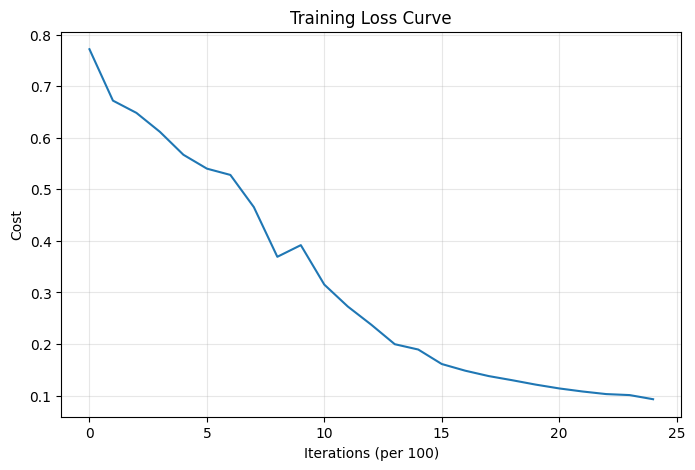

In [22]:
# Plot learning curve
plt.figure(figsize=(8, 5))
plt.plot(costs)
plt.ylabel('Cost')
plt.xlabel('Iterations (per 100)')
plt.title('Training Loss Curve')
plt.grid(True, alpha=0.3)
plt.show()

## 7. Evaluate Model

In [23]:
print("Training Set:")
pred_train = predict(train_x, train_y, parameters)

print("\nTest Set:")
pred_test = predict(test_x, test_y, parameters)

Training Set:
Accuracy: 0.9856459330143539

Test Set:
Accuracy: 0.8


## 8. Visualize Predictions

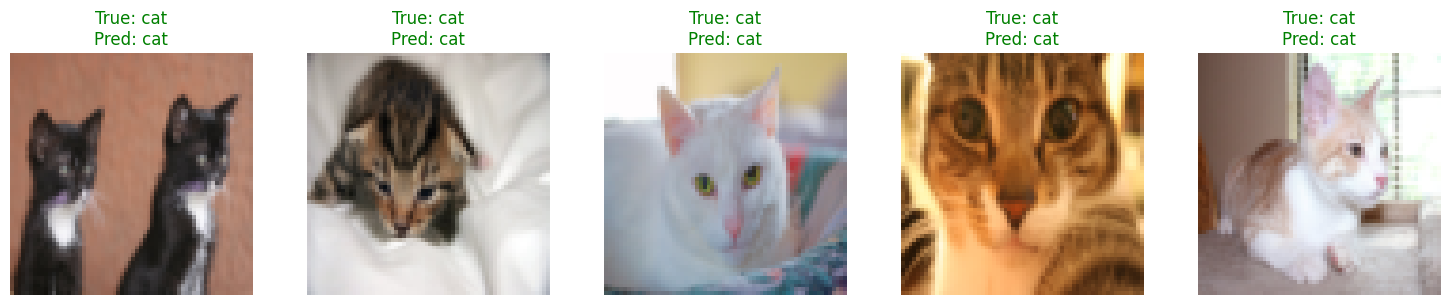

In [24]:
def show_predictions(X_orig, y_true, y_pred, classes, num_samples=5):
    """Display sample predictions with their true labels."""
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    
    for i, ax in enumerate(axes):
        ax.imshow(X_orig[i])
        true_label = classes[int(y_true[0, i])].decode("utf-8")
        pred_label = classes[int(y_pred[0, i])].decode("utf-8")
        color = 'green' if true_label == pred_label else 'red'
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

show_predictions(test_x_orig, test_y, pred_test, classes)

## 9. Test on Custom Image (Optional)

In [25]:
def predict_image(image_path, parameters):
    """Predict whether an image contains a cat."""
    # Load and preprocess image
    img = Image.open(image_path).resize((64, 64))
    img_array = np.array(img).reshape(1, -1).T / 255.0
    
    # Forward propagation
    AL, _ = L_model_forward(img_array, parameters)
    prediction = (AL > 0.5).astype(int)
    
    # Display result
    plt.imshow(img)
    label = "cat" if prediction[0, 0] == 1 else "non-cat"
    confidence = AL[0, 0] if prediction[0, 0] == 1 else 1 - AL[0, 0]
    plt.title(f"Prediction: {label} ({confidence:.1%} confidence)")
    plt.axis('off')
    plt.show()

# Uncomment to test with your own image:
# predict_image("path/to/your/image.jpg", parameters)

## Summary

This notebook demonstrates a complete deep learning pipeline built from scratch:

| Component | Implementation |
|-----------|---------------|
| Forward propagation | Vectorized matrix operations |
| Activation functions | ReLU (hidden), Sigmoid (output) |
| Cost function | Binary cross-entropy |
| Backward propagation | Chain rule gradient computation |
| Optimization | Gradient descent |

The model achieves reasonable accuracy on this small dataset, demonstrating that the fundamental building blocks work correctly. For production use, consider using frameworks like PyTorch or TensorFlow with pretrained models for better performance.